In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

## Описание набора данных

LLM - обнаружение набора текстовых данных, сгенерированных искусственным интеллектом. В этом наборе данных есть как эссе, сгенерированные ИИ, так и эссе, написанные людьми, для целей обучения.

Задача этого набора данных состоит в том, чтобы разработать модель машинного обучения, которая сможет точно определять, было ли эссе написано студентом или LLM. Набор данных для соревнований состоит из эссе, написанных студентами, и эссе, сгенерированных различными LLM.

Набор данных содержит более 28 000 эссе, написанных студентами и сгенерированных искусственным интеллектом.

Характеристики :
- text : содержащий текст эссе
- generated: это целевая метка . 0 — эссе, написанное человеком, 1 — эссе, сгенерированное ИИ

In [2]:
data = pd.read_csv('Training_Essay_Data.csv')
data

,text,generated
0,Car-free cities have become a subject of incre...,1
1,"Car Free Cities Car-free cities, a concept ga...",1
2,A Sustainable Urban Future Car-free cities ...,1
3,Pioneering Sustainable Urban Living In an e...,1
4,The Path to Sustainable Urban Living In an ...,1
...,...,...
29140,There has been a fuss about the Elector Colleg...,0
29141,Limiting car usage has many advantages. Such a...,0
29142,There's a new trend that has been developing f...,0
29143,As we all know cars are a big part of our soci...,0


Задача: Выполнить сравнительный анализ классификаторов при разной предварительной
обработке в задаче распознавание типа текстовых сообщений. 

Алгоритмы классификации:
- NaiveBayes;
- RandomForest;
- LogisticRegression;
- SVM

In [4]:
# наличие пропусков в данных
data.isnull().sum()

text         0
generated    0
dtype: int64

## Предобработка данных

Рассмотрим несколько вариантов обработки текста:
- С учётом регистра,
- Приведение к одному регистру,
- Удаление стоп-слов,
- Выделение специфичных слов.

### Векторизация текста

In [3]:
vectorizer_count = CountVectorizer()

# с учётом регистра
X_count = vectorizer_count.fit_transform(data['text'])

# приведение к одному регистру
X_count_lower = vectorizer_count.fit_transform(data['text'].str.lower())

# удаление стоп-слов
vectorizer_count_stopwords = CountVectorizer(lowercase=True, stop_words='english')
X_count_stopwords = vectorizer_count_stopwords.fit_transform(data['text'])

# выделение специфичных слов
vectorizer_tfidf = TfidfVectorizer(lowercase=True, stop_words='english')
X_tfidf = vectorizer_tfidf.fit_transform(data['text'])


In [4]:
# целевой показатель
y = data['generated']

## Построение классификаторов

In [5]:
def evaluate_models(X, y):
    models = {
        "Naive Bayes": MultinomialNB(),
        "Random Forest": RandomForestClassifier(n_estimators=100),
        "Logistic Regression": LogisticRegression(),
        "SVM": SVC(kernel='linear')
    }

    results = {}
    for model_name, model in models.items():
        # разделение данных на обучающие и тестовые
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
        
        model.fit(X_train, y_train)     # обучение модели
        y_pred = model.predict(X_test)  # прогнозирование
        
        # оценка
        results[model_name] = {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1_score": f1_score(y_test, y_pred)
        }

    return results

In [6]:
# применение различных способов предобработки
results = evaluate_models(X_count, y)
results_lower = evaluate_models(X_count_lower, y)
results_with_stopwords = evaluate_models(X_count_stopwords, y)
results_tfidf = evaluate_models(X_tfidf, y)

# запись результатов
final_results = {
    "с учётом регистра": results,
    "без учёта регистра": results_lower,
    "без стоп-слов": results_with_stopwords,
    "с выделением специфичных слов": results_tfidf,
}


In [9]:
for method, result in final_results.items():
    print(f'\tРезультаты {method}')
    print(pd.DataFrame(result))

	Результаты с учётом регистра
           Naive Bayes  Random Forest  Logistic Regression       SVM
accuracy      0.975640       0.985590             0.994236  0.993412
precision     0.986583       0.993287             0.992243  0.990363
recall        0.951682       0.970319             0.993270  0.993097
f1_score      0.968819       0.981669             0.992756  0.991728
	Результаты без учёта регистра
           Naive Bayes  Random Forest  Logistic Regression       SVM
accuracy      0.975640       0.986139             0.994236  0.993412
precision     0.986583       0.993123             0.992243  0.990363
recall        0.951682       0.971872             0.993270  0.993097
f1_score      0.968819       0.982383             0.992756  0.991728
	Результаты без стоп-слов
           Naive Bayes  Random Forest  Logistic Regression       SVM
accuracy      0.976532       0.986139             0.992040  0.990393
precision     0.980102       0.990872             0.988979  0.985574
recall        0.

### Визуализация результатов

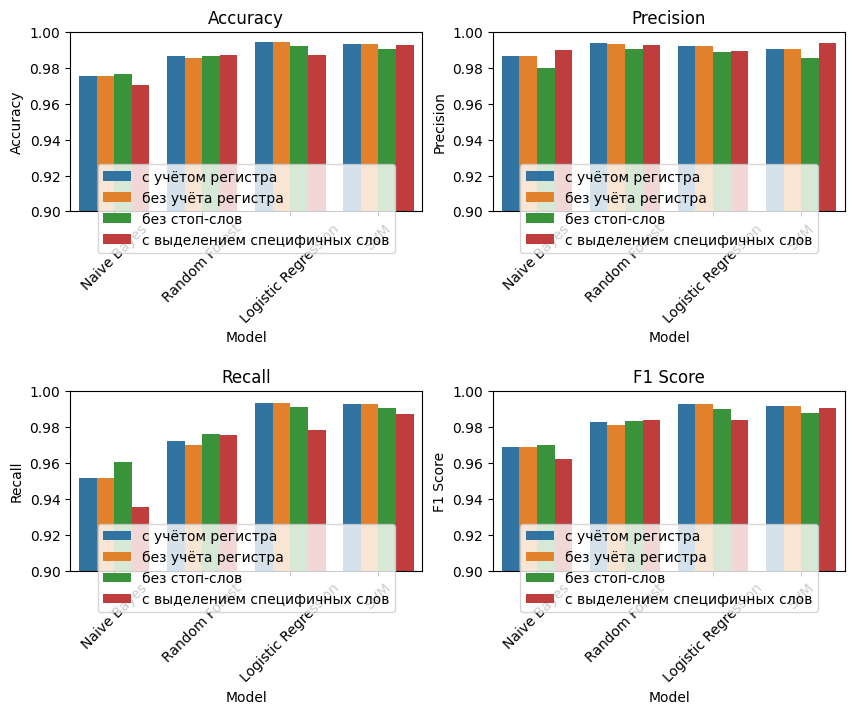

In [38]:
# создание пустого DataFrame
metrics_list = []

# заполнение списка результатов
for method, results in final_results.items():
    for model, metrics in results.items():
        metrics_list.append({
            "Model": model,
            "Accuracy": metrics['accuracy'],
            "Precision": metrics['precision'],
            "Recall": metrics['recall'],
            "F1 Score": metrics['f1_score'],
            "Preprocessing": method
        })

# Преобразование списка в DataFrame
metrics = pd.DataFrame(metrics_list)

k = 1
plt.figure(figsize=(10,7))
# построение графиков
for metric in ['Accuracy','Precision','Recall','F1 Score']:
    plt.subplot(2, 2, k)
    plt.subplots_adjust(hspace=1)
    plt.ylim(0.9, 1)
    plt.xticks(rotation=45)
    plt.title(metric)
    sns.barplot(data=metrics, x='Model', y=metric, hue='Preprocessing')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.3), ncol=1)
    k += 1
plt.show()


## Уникальные слова в классах

In [55]:
# разделение данных по классам
human_essays = data[data['generated'] == 0]['text']
ai_essays = data[data['generated'] == 1]['text']

# векторизация текстов
human_vectorizer = CountVectorizer(lowercase=True, stop_words='english')
X_human = human_vectorizer.fit_transform(human_essays)

ai_vectorizer = CountVectorizer(lowercase=True, stop_words='english')
X_ai = ai_vectorizer.fit_transform(ai_essays)

# анализ уникальных слов
human_words = set(human_vectorizer.get_feature_names_out())
ai_words = set(ai_vectorizer.get_feature_names_out())

unique_human_words = human_words - ai_words     # уникальные слова для человека
unique_ai_words = ai_words - human_words        # уникальные слова для ИИ

print("Уникальные слова для человека:", unique_human_words)
print("Уникальные слова для ИИ:", unique_ai_words)

Уникальные слова для человека: {'haviig', 'hasardious', 'bealives', 'flanked', 'couped', 's26', 'bicylce', 'proper_name', 'simiple', 'camppaign', 'arounld', 'resuers', 'miscounting', 'actuallity', 'benifitting', 'appearded', 'sumester', 'polluion', 'avacadoes', 'ludacrisy', 'whild', 'sulk', 'feelinf', 'euro', 'electol', 'peop0le', 'rhee', 'thecomputer', 'momment', 'specally', 'osmethin', 'populaaion', 'msucle', 'carell', 'knowone', 'enviroiment', 'oversize', 'strang', 'bigest', 'sweltering', 'deam', 'ancident', 'probem', 'aeoale', 'kernal', 'manty', 'sacrificies', 'umbered', '161', 'refeused', 'tralks', 'wroth', 'emitiones', 'taped', 'everybudy', 'perople', 'iimply', 'contuie', 'reltionship', 'disspear', 'clump', 'planor', 'prusite', 'wasent', 'exsplosives', 'asn', 'omputercould', 'accuratley', 'alie', 'degerees', 'revels', 'fahrenhait', 'diffrenf', 'supportingthe', 'furms', 'soleil', 'thje', 'persistsand', 'blinked', 'obsevre', 'confortble', 'centeri', 'busnes', 'lmost', 'cutcome', 'a

In [12]:
# Функция для удаления уникальных слов из текста
def remove_unique_words(text, unique_words):
    # Разбиваем текст на слова
    words = text.split()
    # Убираем уникальные слова
    filtered_words = [word for word in words if word.lower() not in unique_words]
    # Объединяем слова обратно в текст
    return ' '.join(filtered_words)

# Создаем новый столбец с текстами без уникальных слов
data['text_without_unique'] = data.apply(
    lambda row: remove_unique_words(
        row['text'], 
        unique_human_words if row['generated'] == 0 else unique_ai_words
    ), 
    axis=1
)
data

,text,generated,text_without_unique
0,Car-free cities have become a subject of incre...,1,Car-free cities have become a subject of incre...
1,"Car Free Cities Car-free cities, a concept ga...",1,"Car Free Cities Car-free cities, a concept gai..."
2,A Sustainable Urban Future Car-free cities ...,1,A Sustainable Urban Future Car-free cities are...
3,Pioneering Sustainable Urban Living In an e...,1,Pioneering Sustainable Urban Living In an era ...
4,The Path to Sustainable Urban Living In an ...,1,The Path to Sustainable Urban Living In an age...
...,...,...,...
29140,There has been a fuss about the Elector Colleg...,0,There has been a fuss about the Elector Colleg...
29141,Limiting car usage has many advantages. Such a...,0,Limiting car usage has many advantages. Such a...
29142,There's a new trend that has been developing f...,0,There's a new trend that has been developing f...
29143,As we all know cars are a big part of our soci...,0,As we all know cars are a big part of our soci...


In [13]:
vectorizer = CountVectorizer()

# с учётом регистра
X_count_wu = vectorizer.fit_transform(data['text'])

# приведение к одному регистру
X_count_lower_wu = vectorizer.fit_transform(data['text'].str.lower())

# удаление стоп-слов
vectorizer_count_stopwords = CountVectorizer(lowercase=True, stop_words='english')
X_count_stopwords_wu = vectorizer_count_stopwords.fit_transform(data['text'])

# выделение специфичных слов
vectorizer_tfidf = TfidfVectorizer(lowercase=True, stop_words='english')
X_tfidf_wu = vectorizer_tfidf.fit_transform(data['text'])

In [18]:
# применение различных способов предобработки
results_wu = evaluate_models(X_count_wu, y)
results_lower_wu = evaluate_models(X_count_lower_wu, y)
results_with_stopwords_wu = evaluate_models(X_count_stopwords_wu, y)
results_tfidf_wu = evaluate_models(X_tfidf_wu, y)

# запись результатов
final_results_wu = {
    "с учётом регистра": results_wu,
    "без учёта регистра": results_lower_wu,
    "без стоп-слов": results_with_stopwords_wu,
    "с выделением специфичных слов": results_tfidf_wu
}

In [15]:
for method, result in final_results_wu.items():
    print(f'\tРезультаты {method}')
    print(pd.DataFrame(result))

	Результаты с учётом регистра
           Naive Bayes  Random Forest  Logistic Regression       SVM
accuracy      0.975640       0.985384             0.994236  0.993412
precision     0.986583       0.993633             0.992243  0.990363
recall        0.951682       0.969456             0.993270  0.993097
f1_score      0.968819       0.981396             0.992756  0.991728
	Результаты без учёта регистра
           Naive Bayes  Random Forest  Logistic Regression       SVM
accuracy      0.975640       0.985315             0.994236  0.993412
precision     0.986583       0.993632             0.992243  0.990363
recall        0.951682       0.969284             0.993270  0.993097
f1_score      0.968819       0.981307             0.992756  0.991728
	Результаты без стоп-слов
           Naive Bayes  Random Forest  Logistic Regression       SVM
accuracy      0.976532       0.986688             0.992040  0.990393
precision     0.980102       0.991747             0.988979  0.985574
recall        0.

### Визуализация результатов без уникальных слов

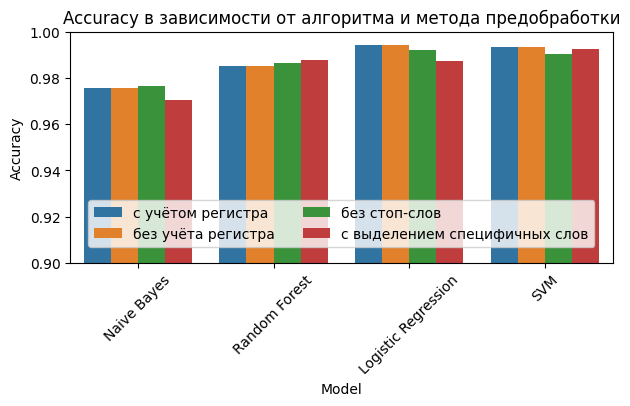

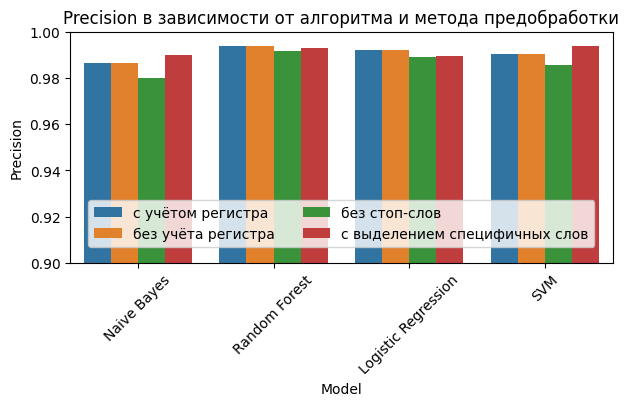

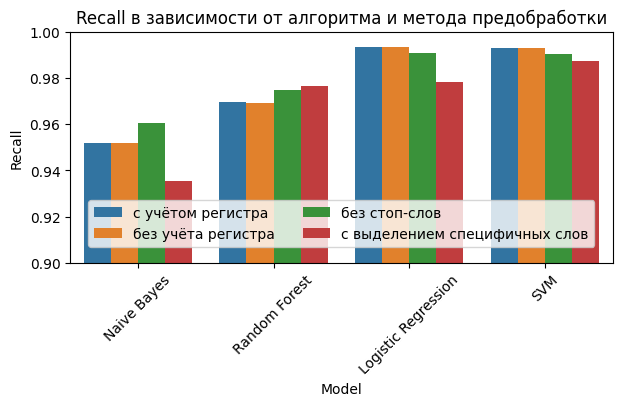

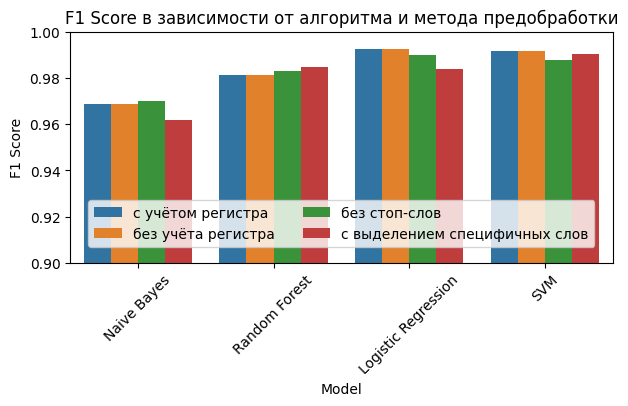

In [16]:
# создание пустого DataFrame
metrics_list = []

# заполнение списка результатов
for method, results in final_results_wu.items():
    for model, metrics in results.items():
        metrics_list.append({
            "Model": model,
            "Accuracy": metrics['accuracy'],
            "Precision": metrics['precision'],
            "Recall": metrics['recall'],
            "F1 Score": metrics['f1_score'],
            "Preprocessing": method
        })

# Преобразование списка в DataFrame
metrics_df = pd.DataFrame(metrics_list)

# построение графиков
for metric in ['Accuracy','Precision','Recall','F1 Score']:
    plt.figure(figsize=(7, 3))
    plt.ylim(0.9, 1)
    sns.barplot(data=metrics_df, x='Model', y=metric, hue='Preprocessing')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.3), ncol=2) 
    plt.title(f'{metric} в зависимости от алгоритма и метода предобработки')
    plt.xticks(rotation=45)    
    plt.show()


## Анализ качетва работы при разных способах предобработки

In [59]:
# выделение специфичных слов
vectorizer_tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = vectorizer_tfidf.fit_transform(data['text'])

### Random Forest

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.5, random_state=42)

# Обучение модели
rf = RandomForestClassifier(n_estimators=100, max_features=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9856584093872229

Самые важные признаки:
1. additionally - Важность: 0.02740664051017094
2. just - Важность: 0.02206402656682585
3. potential - Важность: 0.019073770449501957
4. provide - Важность: 0.018930902981070145
5. good - Важность: 0.014145751714939949
6. important - Важность: 0.01362921318368449
7. want - Важность: 0.012489079037580786
8. going - Важность: 0.012242261547795768
9. say - Важность: 0.011425184601877863
10. know - Важность: 0.011347351193712824


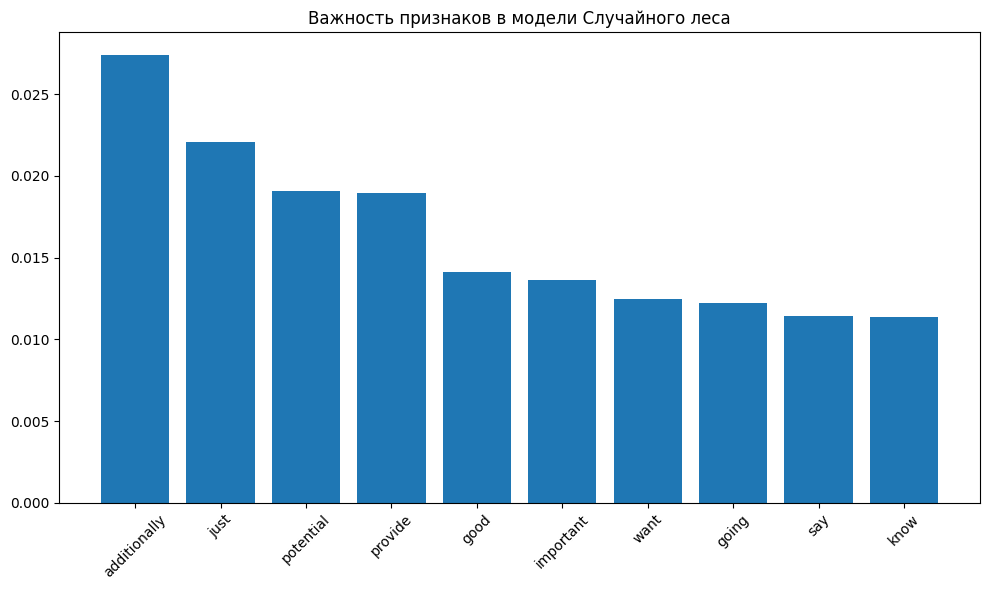

In [58]:
# Получение важности признаков
feature_importances = rf.feature_importances_

# Получение названий признаков
feature_names = vectorizer_tfidf.get_feature_names_out()

# Сортировка по важности
indices = np.argsort(feature_importances)[::-1]

# Вывод наиболее важных признаков
print("Самые важные признаки:")
for i in range(10):
    print(f"{i+1}. {feature_names[indices[i]]} - Важность: {feature_importances[indices[i]]}")

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.title("Важность признаков в модели Случайного леса")
plt.bar(range(10), feature_importances[indices[:10]], align="center")
plt.xticks(range(10), [feature_names[i] for i in indices[:10]], rotation=45)
plt.tight_layout()
plt.show()

### Logistic Regression

In [63]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
accuracy_score(y_test, y_pred)

0.9879914911137034

Самые важные признаки:
1. potential - Важность: 4.31456535621436
2. important - Важность: 4.151795270699778
3. additionally - Важность: 3.7235614731396183
4. provide - Важность: 3.4701333398850793
5. education - Важность: 3.093056428092258
6. quality - Важность: 2.910656952368762
7. risks - Важность: 2.8680232853885235
8. ensures - Важность: 2.7934929294614994
9. understanding - Важность: 2.6735635518377787
10. communities - Важность: 2.610132937579811


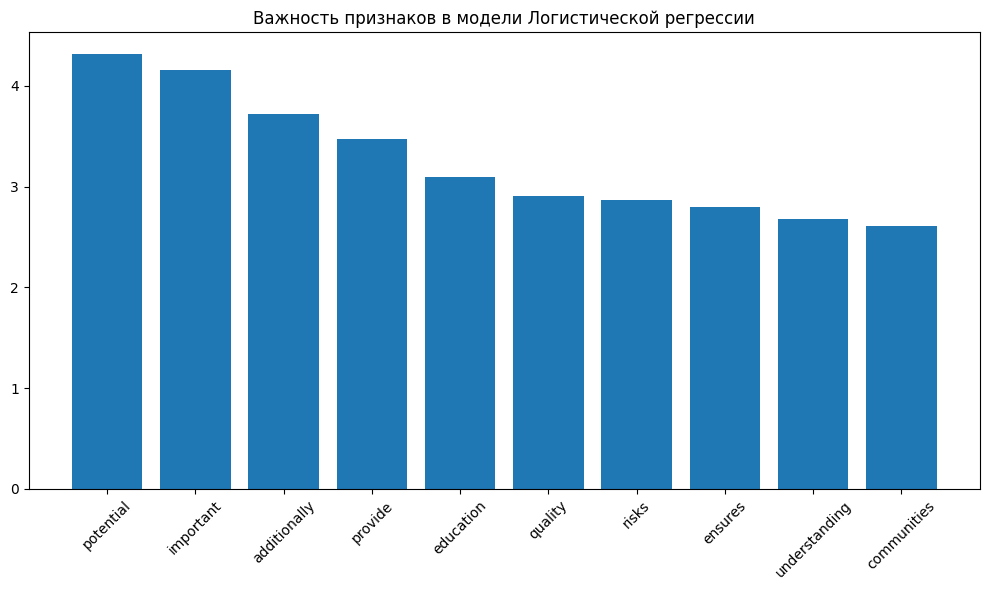

In [53]:
# Получение коэффициентов
coefficients = lr.coef_[0]

# Получение названий признаков
feature_names = vectorizer_tfidf.get_feature_names_out()

# Сортировка по важности
indices = np.argsort(coefficients)[::-1]

# Вывод наиболее важных признаков
print("Самые важные признаки:")
for i in range(10):
    print(f"{i+1}. {feature_names[indices[i]]} - Важность: {coefficients[indices[i]]}")

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.title("Важность признаков в модели Логистической регрессии")
plt.bar(range(10), coefficients[indices[:10]], align="center")
plt.xticks(range(10), [feature_names[i] for i in indices[:10]], rotation=45)
plt.tight_layout()
plt.show()

### SVM

In [64]:
# Обучение модели с линейным ядром
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy_score(y_test, y_pred)

0.9924517944143278

In [67]:
# Получение коэффициентов
coefficients = svm.coef_[0]

# Получение названий признаков
feature_names = vectorizer_tfidf.get_feature_names_out()

# Сортировка по важности
indices = np.argsort(coefficients)[::-1]

# Вывод наиболее важных признаков
print("Самые важные признаки:")
for i in range(10):
    print(f"{i+1}. {feature_names[indices[i]]} - Важность: {coefficients[indices[i]]}")

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.title("Важность признаков в модели Логистической регрессии")
plt.bar(range(10), coefficients[indices[:10]], align="center")
plt.xticks(range(10), [feature_names[i] for i in indices[:10]], rotation=45)
plt.tight_layout()
plt.show()

  (0, 4823)	0.13086322919819546
  (0, 2016)	0.23961163424268955
  (0, 3172)	0.07783088609849009
  (0, 4335)	0.11063677735536419
  (0, 4661)	0.0004650709932947347
  (0, 3155)	0.07739453534968646
  (0, 197)	0.03868671592523767
  (0, 123)	0.03751505188141038
  (0, 1347)	0.07988906950614702
  (0, 1372)	0.11798603685709169
  (0, 3948)	0.18040912477060617
  (0, 4292)	0.0862934582176777
  (0, 4687)	0.24464760705352545
  (0, 4725)	0.14453429570193815
  (0, 4615)	0.0637358844032341
  (0, 2017)	0.22012691021784395
  (0, 4932)	0.10521223649429862
  (0, 2707)	0.15555662533565445
  (0, 1307)	0.4107381455223449
  (0, 61)	0.174589133203315
  (0, 372)	0.055759358085492115
  (0, 722)	0.05040886598345389
  (0, 4274)	0.024345739250648278
  (0, 3918)	0.09160918926492972
  (0, 4590)	0.015833831674718656
  :	:
  (0, 1772)	-0.3865003090853507
  (0, 1599)	0.32275177185424236
  (0, 1590)	0.08850144824671591
  (0, 1586)	-0.6400188376790692
  (0, 1512)	-0.03796689959920134
  (0, 1226)	-0.44852487806473396
  (0, 